# Analyzing NYC High School Data using pandas
The objective of this project is to analyze NYC high school data of SAT score results to identify which factors affect those results. Using pandas, various datasets are combined in order to create a comprehensive picture of all the factors at play.
The various data sets are:
* [SAT scores by school](https://data.cityofnewyork.us/Education/2012-SAT-Results/f9bf-2cp4)
* [School attendance](https://data.cityofnewyork.us/Education/2010-2011-School-Attendance-and-Enrollment-Statist/7z8d-msnt)
* [Class size](https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3)
* [AP test results](https://data.cityofnewyork.us/Education/2010-AP-College-Board-School-Level-Results/itfs-ms3e)
* [Graduation outcomes](https://data.cityofnewyork.us/Education/2005-2010-Graduation-Outcomes-School-Level/vh2h-md7a)
* [Demographics](https://data.cityofnewyork.us/Education/2006-2012-School-Demographics-and-Accountability-S/ihfw-zy9j)
* [School survey](https://data.cityofnewyork.us/Education/2011-NYC-School-Survey/mnz3-dyi8)

## Reading the data files
Let's first read all the .csv files into pandas dataframes and include each in a data dictionary.

In [2]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    print(d.head())
    data[f.replace(".csv", "")] = d

      DBN                             SchoolName AP Test Takers   \
0  01M448           UNIVERSITY NEIGHBORHOOD H.S.              39   
1  01M450                 EAST SIDE COMMUNITY HS              19   
2  01M515                    LOWER EASTSIDE PREP              24   
3  01M539         NEW EXPLORATIONS SCI,TECH,MATH             255   
4  02M296  High School of Hospitality Management               s   

  Total Exams Taken Number of Exams with scores 3 4 or 5  
0                49                                   10  
1                21                                    s  
2                26                                   24  
3               377                                  191  
4                 s                                    s  
   CSD BOROUGH SCHOOL CODE                SCHOOL NAME GRADE  PROGRAM TYPE  \
0    1       M        M015  P.S. 015 Roberto Clemente     0K       GEN ED   
1    1       M        M015  P.S. 015 Roberto Clemente     0K          CTT   
2    1

## Reading the survey files
The two surveys are in different format, tab delimited text files, which can be combined into a single dataframe. The relevant columns are extracted and added to the data dictionary.

In [3]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0, sort=False)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

## Cleaning the data
### Adding DBN column to the class size data
A unique identifier for every school allows us to relate data between various tables. Every dataframe contains a DBN column that uniquely identifies the school, except for the class size dataframe. However, this DBN value can be recreated by combined the CSD and school code values. Padding the numerical csd value is necessary to ensure full compatibility.

In [4]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

### Converting columns to numeric
To facilitate analysis,
* SAT result values can be converted to numeric and added up to a global score.
* AP test values can be converted to numeric
* Geographic data from the HS directory can be captured via regex and converted to numeric.

In [5]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]


cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']
for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")
    
    
def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")



### Condensing the datasets
To limit our analysis to relevant data,
* Let's filter our class size data to only contain values for gen ed programsm, grade 9-12, and combine the class size accross various subjects into the average class size
* Limit the demographics data to the 2011-2012 school year
* Limit the graduation data to the latest year available, 2006, and rows that represent the full data (total cohort), not a subset

In [6]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]
class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

### Combining the datasets
With the DBN serving as a unique identifier of each school and duplicates removed, the datasets can now be combined.
Before performing these joins, let's take a look at how much data might be missing in each.

In [7]:
for dataset in data:
    print(dataset)
    data[dataset].info()
    print('\n')

ap_2010
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 258 entries, 0 to 257
Data columns (total 5 columns):
DBN                                     258 non-null object
SchoolName                              258 non-null object
AP Test Takers                          233 non-null float64
Total Exams Taken                       233 non-null float64
Number of Exams with scores 3 4 or 5    151 non-null float64
dtypes: float64(3), object(2)
memory usage: 10.2+ KB


class_size
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583 entries, 0 to 582
Data columns (total 8 columns):
DBN                                  583 non-null object
CSD                                  583 non-null int64
NUMBER OF STUDENTS / SEATS FILLED    583 non-null float64
NUMBER OF SECTIONS                   583 non-null float64
AVERAGE CLASS SIZE                   583 non-null float64
SIZE OF SMALLEST CLASS               583 non-null float64
SIZE OF LARGEST CLASS                583 non-null float64
SCHOOLWIDE P

Since our goal is to analyze SAT values, we will use the SAT data as the baseline on which to join additional datasets. It looks like ap_2010 and graduation data have the fewest entries (rows), which means they are missing unique DBN values that exist in the SAT data. We will begin by joining those as a left join in order to keep our SAT data as large as possible. The other datasets can be added using inner joins.

In [8]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)
combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 363 entries, 0 to 362
Columns: 159 entries, DBN to lon
dtypes: float64(51), int64(16), object(92)
memory usage: 453.8+ KB


### Add a school district column for mapping

In [9]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

## Analyzing the data
### Correlation between SAT scores and survey fields
Now that the data is clean, we can begin our analysis. The first step to identify which factors might impact the SAT is to calculate correlation factors. Luckily, pandas makes that easy.

In [10]:
correlations = combined.corr()
correlations = correlations["sat_score"].sort_values(ascending=False).dropna()
print(correlations)

sat_score                               1.000000
SAT Writing Avg. Score                  0.987771
SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
white_per                               0.620718
asian_per                               0.570730
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
asian_num                               0.475445
Number of Exams with scores 3 4 or 5    0.463245
white_num                               0.449559
N_s                                     0.423463
N_p                                     0.421530
total_students                          0.407827
NUMBER OF STUDENTS / SEATS FILLED       0.394626
female_num                              0.388631
AVERAGE CLASS SIZE                      0.381014
total_enrollment                        0.367857
NUMBER OF SECTIONS                      0.362673
aca_s_11                                0.339435
saf_s_11            

Let's scope our analysis down to the survey fields which indicate a perception of various school attributes.

Text(0.5, 1.0, 'Correlation of survey fields with SAT score')

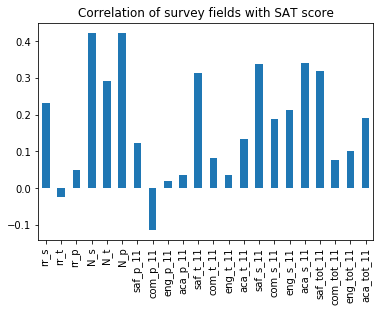

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

survey_fields.remove("DBN")
correlations[survey_fields].plot(kind='bar')
plt.title('Correlation of survey fields with SAT score')

According to the data dictionary downloaded with the data, the factors that correlate the most positively with SAT scores are:
* N_s, N_p : number of student and parent respondants
* saf_s_11, saf_t_11, saf_tot_11 : Safety and Respect score based on student and teacher responses, and total score
* aca_s_11 Academic expectations based on student scores

### Investigating safety score correlation
Let's dig more into the impact of safety and respect scores from student responses and the SAT scores by visualizing their relationship in a scatter plot.

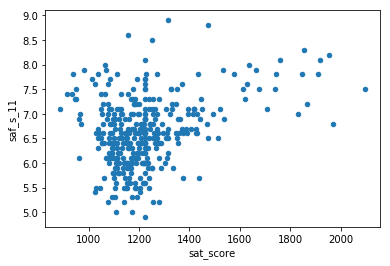

In [12]:
combined.plot.scatter(x='sat_score', y='saf_s_11')

There is clearly a positive correlation, however some schools performing highly on safety and respect still do not achieve good SAT scores.
### Visualizing safety by district

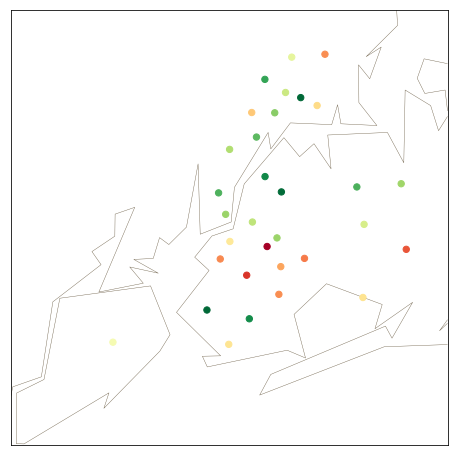

In [13]:
districts = combined.groupby('school_dist').agg(numpy.mean)
districts.reset_index(inplace= True)

from mpl_toolkits.basemap import Basemap
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)
plt.figure(figsize=(8,8))
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

longitudes= districts['lon'].tolist()
latitudes= districts['lat'].tolist()

m.scatter(longitudes, latitudes, s=40, zorder=2, latlon=True, c=districts['saf_s_11'], cmap='RdYlGn')

While Manhattan and Queens seem to have higher safety scores, Brooklyn is lower.
### Correlation between Race percentages and SAT scores

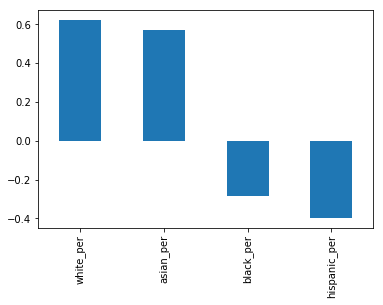

In [14]:
correlations[['white_per', 'asian_per', 'black_per', 'hispanic_per']].plot(kind='bar')

White and asian percentages correlate with higher scores, while the neg correlation for black percentages is smaller. Hispanic is worse.

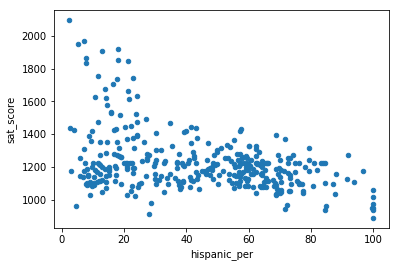

In [15]:
combined.plot.scatter(y='sat_score', x='hispanic_per')

Clearly high hispanic percentage schools perform poorly on SAT, but not all low hispanic schools perform well either.

In [16]:
print(combined[combined['hispanic_per'] >95]['SCHOOL NAME'])

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


These are international schools, the students are learning english, hence the lower scores.

In [17]:
print(combined[(combined['hispanic_per'] <10) & (combined['sat_score'] >1800)]['SCHOOL NAME'])

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


These are elite tech high schools that specialize in STEM.

### Correlation between gender and SAT scores

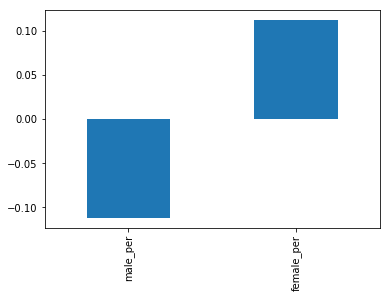

In [18]:
correlations[['male_per', 'female_per']].plot(kind='bar')

Small correlation between female and higher scores and males and lower scores.

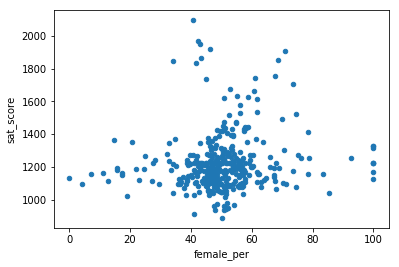

In [19]:
combined.plot.scatter(y='sat_score', x='female_per')

Female only schools do not perform better than schools in the 60 range.

In [20]:
print(combined[(combined['female_per'] >60) & (combined['sat_score'] >1700)]['SCHOOL NAME'])

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


These are all elite schools that require entrance exams.

### Correlation between percentage of AP test takers and SAT scores

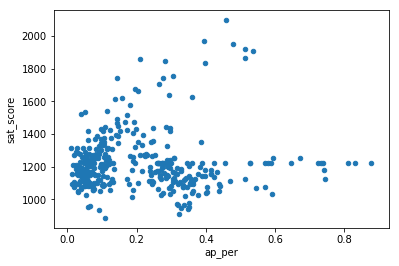

In [21]:
combined['ap_per'] = combined['AP Test Takers '] / combined ['total_enrollment']
combined.plot.scatter(y='sat_score', x='ap_per')

It seems that having very high AP takers does not automatically improve SAT scores, but there is still a small correlation.

## Conclusion
Using the power of pandas, we were able to combine disparate data sets into a single dataframe. This dataframe was easily analyzed to obtain insights into the factors that affect SAT scores.